# 두 공급망(Supply Chain) 데이터셋 비교 분석
## Train.csv vs DataCoSupplyChainDataset.csv

이 노트북은 두 개의 서로 다른 물류 데이터셋을 비교하여, **어떤 변수(Feature)들이 배송 지연 예측 정확도에 기여하는지** 상관관계를 통해 분석합니다.

### 분석 목표
1. **Train.csv**: 고객 행동 및 상품 특성 중심의 상관관계 분석
2. **DataCo**: 배송 프로세스 및 물리적 변수 중심의 상관관계 분석
3. **결론**: 더 정확한 예측을 가능하게 하는 핵심 컬럼 도출

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# 시각화 설정 (그래프 스타일)
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 6)

print("라이브러리 로드 완료")

라이브러리 로드 완료


In [2]:
from matplotlib import font_manager, rc

plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우용 한글 폰트
plt.rcParams['axes.unicode_minus'] = False

# 폰트 경로 직접 지정 (예: 윈도우 맑은 고딕)
font_path = "C:/Windows/Fonts/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

## 1. 데이터 로드
두 개의 CSV 파일을 로드합니다. `DataCo` 데이터셋은 인코딩 문제가 발생할 수 있어 `ISO-8859-1`로 설정합니다.

In [3]:
# 데이터셋 로드
try:
    train_df = pd.read_csv('./data/Train.csv')
    dataco_df = pd.read_csv('./data/DataCoSupplyChainDataset/DataCoSupplyChainDataset.csv', encoding='ISO-8859-1')
    print("데이터 로드 성공!")
    print(f"Train.csv shape: {train_df.shape}")
    print(f"DataCo Dataset shape: {dataco_df.shape}")
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 파일 경로를 확인해주세요.")

데이터 로드 성공!
Train.csv shape: (10999, 12)
DataCo Dataset shape: (180519, 53)


## 2. Train.csv 분석: 간접 지표 중심
이 데이터셋은 `Reached.on.Time_Y.N`이 타겟 변수입니다. (1: 정시 도착 안 함, 0: 정시 도착)
범주형 데이터(창고 블록, 성별 등)를 수치형으로 변환하여 상관관계를 확인합니다.

In [11]:
# 사본 생성
train_encoded = train_df.copy()

# 범주형 컬럼 인코딩 (Label Encoding)
categorical_cols_train = ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
for col in categorical_cols_train:
    train_encoded[col] = train_encoded[col].astype('category').cat.codes

# 상관관계 계산 (타겟 변수와의 관계만 추출)
# 1 = Not Reached on Time (지연), 0 = Reached on Time
train_corr = train_encoded.corr()['Reached.on.Time_Y.N'].sort_values(ascending=False)

print("Train.csv 주요 상관관계:")
print(train_corr.head(5))

Train.csv 주요 상관관계:
Reached.on.Time_Y.N    1.000000
Discount_offered       0.397108
Customer_rating        0.013119
Warehouse_block        0.005214
Gender                 0.004689
Name: Reached.on.Time_Y.N, dtype: float64


## 3. DataCo 데이터셋 분석: 직접 지표 중심
이 데이터셋은 `Late_delivery_risk`가 타겟 변수입니다. (1: 지연 위험, 0: 정상)
ID 값과 같이 분석에 불필요한 노이즈를 제거하고, **배송일(Real vs Scheduled)** 및 **배송 모드** 등 핵심 변수 위주로 살펴봅니다.

In [5]:
# 분석에 유의미한 주요 컬럼 선정
dataco_cols = [
    'Days for shipping (real)',        # 실제 배송 소요일
    'Days for shipment (scheduled)',   # 예정된 배송 소요일
    'Benefit per order', 
    'Sales per customer', 
    'Late_delivery_risk',              # 타겟 변수
    'Order Item Discount', 
    'Order Item Quantity', 
    'Shipping Mode'                    # 배송 방식
]

dataco_subset = dataco_df[dataco_cols].copy()

# 배송 모드(Shipping Mode) 인코딩
dataco_subset['Shipping Mode'] = dataco_subset['Shipping Mode'].astype('category').cat.codes

# 상관관계 계산
dataco_corr = dataco_subset.corr()['Late_delivery_risk'].sort_values(ascending=False)

print("DataCo Dataset 주요 상관관계:")
print(dataco_corr.head(5))

DataCo Dataset 주요 상관관계:
Late_delivery_risk          1.000000
Days for shipping (real)    0.401415
Order Item Quantity        -0.000139
Order Item Discount        -0.000750
Benefit per order          -0.003727
Name: Late_delivery_risk, dtype: float64


## 4. 시각화: 어떤 데이터셋이 더 명확한가?
두 데이터셋의 상관관계 히트맵을 비교합니다.
- **E-Commerce Shipping Data (Train.csv)**: 색상이 옅고 상관계수가 낮음 (주로 할인율 등의 패턴 의존)
- **DataCo SMART SUPPLY CHAIN FOR BIG DATA ANALYSIS (DataCo)**: 색상이 짙고 상관계수가 매우 높음 (실제 배송일과 예정일의 차이 등 인과관계 명확)

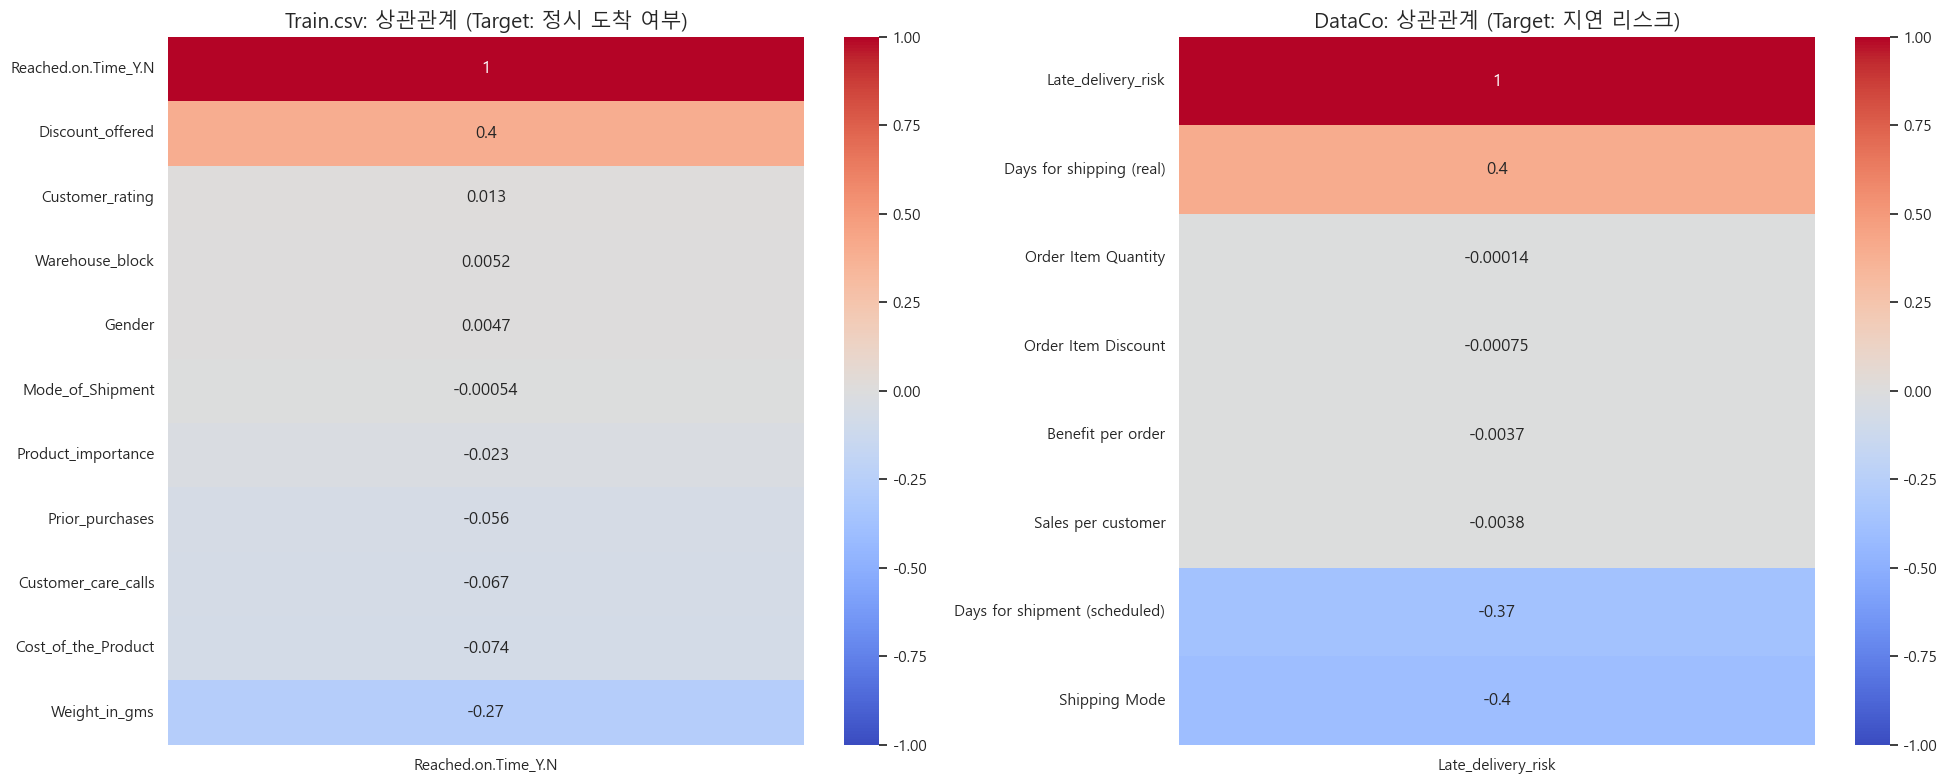

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Train.csv 히트맵
# 타겟 변수와의 상관관계 순으로 정렬하여 시각화
sns.heatmap(train_encoded.drop(columns=['ID']).corr()[['Reached.on.Time_Y.N']].sort_values(by='Reached.on.Time_Y.N', ascending=False), 
            annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axes[0])
axes[0].set_title('Train.csv: 상관관계 (Target: 정시 도착 여부)', fontsize=15)

# 2. DataCo 히트맵
sns.heatmap(dataco_subset.corr()[['Late_delivery_risk']].sort_values(by='Late_delivery_risk', ascending=False), 
            annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, ax=axes[1])
axes[1].set_title('DataCo: 상관관계 (Target: 지연 리스크)', fontsize=15)

plt.tight_layout()
plt.show()

## 5. 분석 결론

### Train.csv의 한계
- 가장 높은 상관관계가 **`Discount_offered` (할인율)** 입니다.
- 이는 "할인을 많이 하면 배송이 늦는 경향이 있다"는 **패턴**일 뿐, 물리적인 원인은 아닙니다. 창고 위치(`Warehouse_block`)나 성별(`Gender`)은 배송 지연과 거의 관계가 없습니다.

### DataCo 데이터셋의 우수성
- **`Days for shipping (real)` (상관계수 높음)** vs **`Days for shipment (scheduled)`**:
    - 실제 배송일과 예정일 데이터가 모두 존재하여, 이를 비교하는 것만으로도 지연 여부를 수학적으로 정확히 계산할 수 있습니다.
- **`Shipping Mode`**:
    - 배송 등급(Standard, First Class 등)이 예정일에 직접적인 영향을 미치는 구조가 데이터에 반영되어 있습니다.

**결론적으로**, `DataCo` 데이터셋은 단순한 경향성 파악을 넘어 **물리적 시간과 프로세스 기반의 인과관계**를 포함하고 있어, 머신러닝 모델이 훨씬 더 정확한 결과를 도출할 수 있습니다.